## Modeling

In [19]:
import re
import cv2 # Albumentation transform을 쓰려면 꼭 cv2 library를 이용해야함.
import time
import random
import warnings

from PIL import Image # PIL = Python Image Library
from sklearn.model_selection import GroupKFold


!pip install albumentations==0.4.6
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.core.transforms_interface import ImageOnlyTransform

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

paddingSize= 0

warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 117 kB 2.1 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=b7716672c2c5767beafab94c6148ea4efc01bf2725a2b5204c8f4ba55a25070c
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1


group K fold

- group by image_id
- 예측의 정확도를 확실히 평가하기 위해서는 train set & valid set에 포함된 image가 겹치지 않도록 할 필요가 있기때문에 이를위해 group k fold를 사용하였음

In [20]:
gkf  = GroupKFold(n_splits = 5)
final_df['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(gkf.split(final_df, groups = final_df.image_id.tolist())): # cf) tolist한다고 unqiue해지는건 아님
    final_df.loc[val_idx, 'fold'] = fold
final_df.head()

,image_id,class_name,class_id,ori_x_min,ori_y_min,ori_x_max,ori_y_max,ori_x_mid,ori_y_mid,ori_w,ori_h,fold
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,170,301,406,401,288,351,236,99,3
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,280,132,358,181,319,156,77,49,2
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,126,59,190,72,158,65,64,12,4
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,301,49,490,434,396,241,188,385,2
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,111,359,134,379,122,369,23,20,4


In [21]:
final_df.groupby('fold')['image_id'].agg(lambda x: x.nunique()).reset_index()
# agg(적용하고 싶은 함수): 함수를 여러 열에 적용하는 함수
# nunique(): 데이터에 고유값들의 수를 출력해주는 함수. (데이터 고유값의 총 수를 알고 싶을때 유용한 함수)

,fold,image_id
0,0,879
1,1,879
2,2,879
3,3,878
4,4,879


In [22]:
#그냥 가정 설정문으로 가정에 맞지않으면 assertionerror가 발생
IMG_SIZE = 512
assert final_df['ori_x_min'].all() <= IMG_SIZE
assert final_df['ori_y_min'].all() <= IMG_SIZE
assert final_df['ori_x_max'].all() <= IMG_SIZE
assert final_df['ori_y_max'].all() <= IMG_SIZE

In [23]:
#확인겸
final_df[final_df.ori_y_min == final_df.ori_y_max]

,image_id,class_name,class_id,ori_x_min,ori_y_min,ori_x_max,ori_y_max,ori_x_mid,ori_y_mid,ori_w,ori_h,fold
11912,a1134e92282815efb505a93105083393,Pleural effusion,10,179,381,206,381,193,381,27,0,1


원래 y_max와 y_min이 별 차이가 나지 않았는데 normalization 후 다시 size(512x512) 재정의시 정수화함에따라 같은 값을 갖게되는 경우가 있었다.
이런 데이터는 삭제하기로 함.

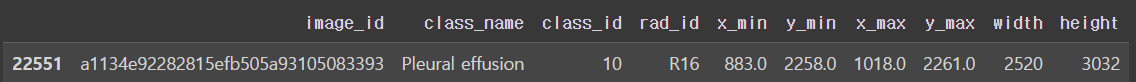

In [24]:
final_df = final_df[final_df.ori_y_min != final_df.ori_y_max].reset_index()
final_df.head()

,index,image_id,class_name,class_id,ori_x_min,ori_y_min,ori_x_max,ori_y_max,ori_x_mid,ori_y_mid,ori_w,ori_h,fold
0,0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,170,301,406,401,288,351,236,99,3
1,1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,280,132,358,181,319,156,77,49,2
2,2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,126,59,190,72,158,65,64,12,4
3,3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,301,49,490,434,396,241,188,385,2
4,4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,111,359,134,379,122,369,23,20,4


In [25]:
final_df = final_df.drop('index', axis = 1)

In [26]:
final_df

,image_id,class_name,class_id,ori_x_min,ori_y_min,ori_x_max,ori_y_max,ori_x_mid,ori_y_mid,ori_w,ori_h,fold
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,170,301,406,401,288,351,236,99,3
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,280,132,358,181,319,156,77,49,2
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,126,59,190,72,158,65,64,12,4
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,301,49,490,434,396,241,188,385,2
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,111,359,134,379,122,369,23,20,4
...,...,...,...,...,...,...,...,...,...,...,...,...
36090,b53d1dd80e99ca6bcef9d592f65d3321,Pleural effusion,10,53,275,124,355,89,315,71,80,0
36091,26d1d5a0ef2e692c6340e74859ffdc53,Pulmonary fibrosis,13,193,131,223,156,208,144,29,25,4
36092,22672ab82c290c20b86863291e25ef6c,ILD,5,74,135,198,308,136,222,123,172,4
36093,db169d0be36123bd55b866d6aa73983b,Other lesion,9,1,119,60,308,30,213,59,189,2


In [26]:
class_dict = dict(set(zip(final_df.class_id, final_df.class_name)))
classes = []
for key in sorted(class_dict.keys()):
    classes.append(class_dict[key])

classes = ['_'] + classes   # adding background
classes

['_',
 'Aortic enlargement',
 'Atelectasis',
 'Calcification',
 'Cardiomegaly',
 'Consolidation',
 'ILD',
 'Infiltration',
 'Lung Opacity',
 'Nodule/Mass',
 'Other lesion',
 'Pleural effusion',
 'Pleural thickening',
 'Pneumothorax',
 'Pulmonary fibrosis']

In [27]:
def label_to_name(id):
  id = int(id)
  id = id-1
  if id == 0:
      return "Aortic enlargement"
  if id == 1:
      return "Atelectasis"
  if id == 2:
      return "Calcification"
  if id == 3:
      return "Cardiomegaly"
  if id == 4:
      return "Consolidation"
  if id == 5:
      return "ILD"
  if id == 6:
      return "Infiltration"
  if id == 7:
      return "Lung Opacity"
  if id == 8:
      return "Nodule/Mass"  
  if id == 9:
      return "Other lesion"
  if id == 10:
      return "Pleural effusion"
  if id == 11:
      return "Pleural thickening"
  if id == 12:
      return "Pneumothorax"
  if id == 13:
      return "Pulmonary fibrosis"
  else:
      return str(id)  

pytorch 에서의 Deep learning
1.   dataset 객체 class 생성 (pytorch는 model에 들어갈 data의 class와 loader를 정의해주어야함.)
2.   dataloader로 dataset 불러오기
3.   trainset, validationset model에 넣고 model 학습
4.   model로 test set inference


In [28]:
class VBDDataset(Dataset): # class to load training data
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique() # image 고유 ID
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms # data의 경로와 불러올 데이터들에 augmentation을 적용하기위해 transform 인자를 만듬

    def __getitem__(self, idx): # image index로 item 불러오기

        image_id = self.image_ids[idx]
        # image ID가 같은 dataframe 가져오기
        records = self.df[self.df['image_id'] == image_id]
        # cv2로 image 불러오기
        image = cv2.imread(f'{self.image_dir}/{image_id}.png', cv2.IMREAD_COLOR)
        # openCV로 각  color를 저장하는 방식인 BGR을 RGB로 변환
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        # 0~1 사이로 scaling
        image /= 255.0
        boxes = records[['ori_x_min', 'ori_y_min', 'ori_x_max', 'ori_y_max']].values
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # list를 torch tensor로 view 변환 (data definition)
        area = torch.as_tensor(area, dtype=torch.float32)
        # all the labels are shifted by 1 to accomodate background
        labels = torch.squeeze(torch.as_tensor((records.class_id.values+1,), dtype=torch.int64))
        
        # 모든 인스턴스는 crowd 상태가 아님을 가정
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([idx])
        target['area'] = area
        target['iscrowd'] = iscrowd
        # transform 적용
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.as_tensor(sample['bboxes'])

        return image, target, image_id

    def __len__(self):
        return self.image_ids.shape[0]

In [29]:
dt = VBDDataset(final_df, train_dir)

In [30]:
# 이미지 tensor로 바꾸기
def get_train_transform():
    return A.Compose([
        ToTensorV2(p=1.0) # albumentations의 경우는 normalize 후 ToTensorV2 사용
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

## 미리 학습된 model로 부터 fine tuning

coco 로 미리 학습 된 model 읽기

In [31]:
#load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

분류기를 새로운 것을 교체

In [32]:
num_classes = 15  # 14 classes + background

# 분류기에서 사용할 입력 특징의 차원 정보 얻음
in_features = model.roi_heads.box_predictor.cls_score.in_features

# 미리 학습된 모델의 머리 부분을 새로운 것으로 교체
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [33]:
# A Class for keeping track of average
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

## testing sample

In [34]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = VBDDataset(final_df, train_dir, get_train_transform())
valid_dataset = VBDDataset(final_df, train_dir, get_valid_transform())


train_data_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

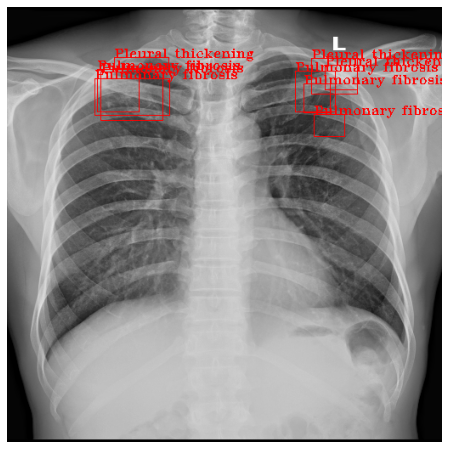

In [35]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

boxes = targets[2]['boxes'].cpu().numpy().astype(np.int32)
sample = images[2].permute(1,2,0).cpu().numpy()
labels= targets[2]['labels'].cpu().numpy().astype(np.int32)
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for i in range(len(boxes)):
    sample = cv2.rectangle(sample,
                  (boxes[i][0], boxes[i][1]),
                  (boxes[i][2], boxes[i][3]),
                  (220, 0, 0), 1)
    sample = cv2.putText(sample, label_to_name(labels[i]), (int(boxes[i][0]), int(boxes[i][1])),cv2.FONT_HERSHEY_TRIPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)

ax.set_axis_off()
ax.imshow(sample)

## training

In [36]:
def get_dataloaders(df, trn_idx, val_idx):
    
    train_ = df.loc[trn_idx,:].reset_index(drop=True)
    valid_ = df.loc[val_idx,:].reset_index(drop=True)
        
    def collate_fn(batch):
        return tuple(zip(*batch))

    train_dataset = VBDDataset(train_, train_dir, get_train_transform())
    valid_dataset = VBDDataset(valid_, train_dir, get_valid_transform())

    train_data_loader = DataLoader(
        train_dataset,
        batch_size=8,
        shuffle=False,
        num_workers=4,
        collate_fn=collate_fn
    )

    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size=4,
        shuffle=False,
        num_workers=4,
        collate_fn=collate_fn
    )
    
    return train_data_loader, valid_data_loader

In [37]:
def train_model(model, dataloader, device, epochs, optimizer, lr_scheduler, fold):
    
    best_loss = 1e10
    loss_hist = Averager()
    itr = 1
    all_losses = []

    for epoch in range(epochs):
        loss_hist.reset() 
    
        for images, targets, image_ids in dataloader:

            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)

            losses = sum(loss for loss in loss_dict.values())
            loss_value = losses.item()

            loss_hist.send(loss_value)
            all_losses.append(loss_value)
            
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            if itr % 50 == 0:
                print(f"Iteration #{itr} loss: {loss_value}")

            itr += 1        
        # saving the model based on training loss for now. - later can be moved to validation
        if loss_hist.value < best_loss:
            best_loss = loss_hist.value
            torch.save(model.state_dict(), f'fasterrcnn_model_{fold}.pt')

        # update the learning rate
        if lr_scheduler is not None:
            lr_scheduler.step()

        print(f"Epoch #{epoch} loss: {loss_hist.value}\n")
        
    return all_losses

In [38]:
def validate_model(model, dataloader, device):
    print("\n Starting Validation ... ")
    loss_hist = Averager()
    itr = 1

    loss_hist.reset() 

    for images, targets, image_ids in dataloader:

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1

    print(f"\nFinal loss: {loss_hist.value}")

In [39]:
def run_fold(fold):
    print(f"Starting fold {fold}")
    start = time.time()
    trn_idx = final_df[final_df['fold'] != fold].index
    val_idx = final_df[final_df['fold'] == fold].index
    
    
    trainloader, valloader = get_dataloaders(final_df, trn_idx, val_idx)
    
    loss_hist = train_model(model, trainloader, device, epochs, optimizer, lr_scheduler, fold)
    
    # plot training loss
    plt.figure(figsize=(8,5))
    plt.plot(loss_hist)
    plt.title("Training Loss Statistic", size=17)
    plt.xlabel("Iteration", size=15)
    plt.ylabel("Loss Value", size=15)

    plt.show()
    
    validate_model(model, valloader, device)
    
    print(f"Completed Fold {fold} in {round(time.time()-start, 2)} seconds")

In [40]:
model.to(device)

# set params for model
params = [p for p in model.parameters() if p.requires_grad]

# set optimizer
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# set lr scheduler
lr_scheduler = None

# set epochs
epochs = 20

# set folds
num_folds = 5

Starting fold 0
Iteration #50 loss: 1.2168303728103638
Iteration #100 loss: 1.2500522136688232
Iteration #150 loss: 0.674476146697998
Iteration #200 loss: 0.8703083992004395
Iteration #250 loss: 1.0784599781036377
Iteration #300 loss: 0.7957245707511902
Iteration #350 loss: 0.5148740410804749
Iteration #400 loss: 0.5821232199668884
Epoch #0 loss: 0.8610094517808069

Iteration #450 loss: 0.9495852589607239
Iteration #500 loss: 0.739628255367279
Iteration #550 loss: 0.9480655789375305
Iteration #600 loss: 0.813789427280426
Iteration #650 loss: 0.7515815496444702
Iteration #700 loss: 0.5225707292556763
Iteration #750 loss: 0.7648341655731201
Iteration #800 loss: 0.6120172739028931
Iteration #850 loss: 0.6474484205245972
Epoch #1 loss: 0.756139943918044

Iteration #900 loss: 0.8079430460929871
Iteration #950 loss: 1.1263301372528076
Iteration #1000 loss: 0.8224641680717468
Iteration #1050 loss: 0.9379873275756836
Iteration #1100 loss: 0.8073723912239075
Iteration #1150 loss: 0.830136001110

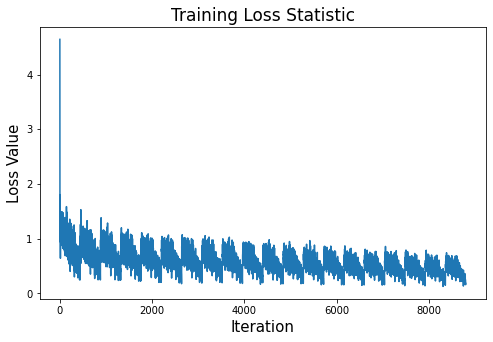


 Starting Validation ... 
Iteration #50 loss: 2.0540874004364014
Iteration #100 loss: 1.1809914112091064
Iteration #150 loss: 1.2396689653396606
Iteration #200 loss: 0.9417006969451904

Final loss: 1.0484442523257298
Completed Fold 0 in 13836.13 seconds
Starting fold 1
Iteration #50 loss: 0.4492008090019226
Iteration #100 loss: 0.6948373317718506
Iteration #150 loss: 0.43739625811576843
Iteration #200 loss: 0.5270086526870728
Iteration #250 loss: 0.4215412437915802
Iteration #300 loss: 0.45929083228111267
Iteration #350 loss: 0.485251784324646
Iteration #400 loss: 0.33497703075408936
Epoch #0 loss: 0.5270878921178255

Iteration #450 loss: 0.6567970514297485
Iteration #500 loss: 0.3874987065792084
Iteration #550 loss: 0.7491517066955566
Iteration #600 loss: 0.4660218060016632
Iteration #650 loss: 0.41489243507385254
Iteration #700 loss: 0.6001615524291992
Iteration #750 loss: 0.3218024969100952
Iteration #800 loss: 0.3525352478027344
Iteration #850 loss: 0.4264424741268158
Epoch #1 los

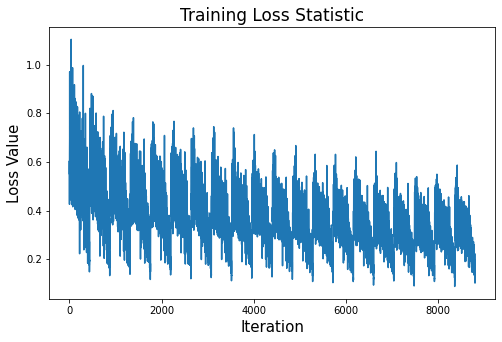


 Starting Validation ... 
Iteration #50 loss: 1.0565733909606934
Iteration #100 loss: 0.7158464193344116
Iteration #150 loss: 0.28497371077537537
Iteration #200 loss: 0.45135849714279175

Final loss: 0.8323875940320167
Completed Fold 1 in 13851.16 seconds
Starting fold 2
Iteration #50 loss: 0.36619246006011963
Iteration #100 loss: 0.31247976422309875
Iteration #150 loss: 0.41482552886009216
Iteration #200 loss: 0.5488585233688354
Iteration #250 loss: 0.36352768540382385
Iteration #300 loss: 0.41359564661979675
Iteration #350 loss: 0.27367478609085083
Iteration #400 loss: 0.43260037899017334
Epoch #0 loss: 0.4084874868054282

Iteration #450 loss: 0.36478349566459656
Iteration #500 loss: 0.4116601049900055
Iteration #550 loss: 0.29892489314079285
Iteration #600 loss: 0.3560999631881714
Iteration #650 loss: 0.5291004180908203
Iteration #700 loss: 0.2510130703449249
Iteration #750 loss: 0.41962379217147827
Iteration #800 loss: 0.3000779449939728
Iteration #850 loss: 0.27695655822753906
Ep

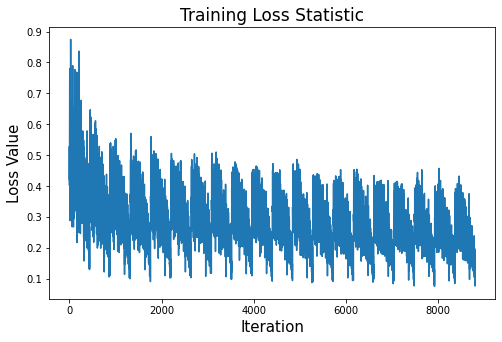


 Starting Validation ... 
Iteration #50 loss: 0.8215429782867432
Iteration #100 loss: 0.5784904956817627
Iteration #150 loss: 0.43710124492645264
Iteration #200 loss: 0.4618024230003357

Final loss: 0.7596395240927284
Completed Fold 2 in 13907.38 seconds
Starting fold 3
Iteration #50 loss: 0.30397868156433105
Iteration #100 loss: 0.31207674741744995
Iteration #150 loss: 0.25805506110191345
Iteration #200 loss: 0.27529317140579224
Iteration #250 loss: 0.3772982656955719
Iteration #300 loss: 0.3158647418022156
Iteration #350 loss: 0.23930948972702026
Iteration #400 loss: 0.22171062231063843
Epoch #0 loss: 0.3385584655641155

Iteration #450 loss: 0.3707767128944397
Iteration #500 loss: 0.36639735102653503
Iteration #550 loss: 0.37764620780944824
Iteration #600 loss: 0.4327980875968933
Iteration #650 loss: 0.33303093910217285
Iteration #700 loss: 0.3400668501853943
Iteration #750 loss: 0.24895423650741577
Iteration #800 loss: 0.15736079216003418
Iteration #850 loss: 0.14333467185497284
Ep

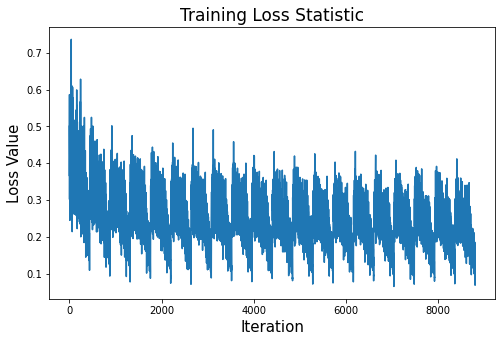


 Starting Validation ... 
Iteration #50 loss: 0.7891213893890381
Iteration #100 loss: 0.20565390586853027
Iteration #150 loss: 0.2839529514312744
Iteration #200 loss: 0.3172586262226105

Final loss: 0.5898039552975785
Completed Fold 3 in 13862.48 seconds
Starting fold 4
Iteration #50 loss: 0.46176010370254517
Iteration #100 loss: 0.388557106256485
Iteration #150 loss: 0.282145231962204
Iteration #200 loss: 0.23196057975292206
Iteration #250 loss: 0.43212956190109253
Iteration #300 loss: 0.24565839767456055
Iteration #350 loss: 0.21676139533519745
Iteration #400 loss: 0.1672779768705368
Epoch #0 loss: 0.29370104790749874

Iteration #450 loss: 0.3372044861316681
Iteration #500 loss: 0.24707423150539398
Iteration #550 loss: 0.3459291458129883
Iteration #600 loss: 0.24150709807872772
Iteration #650 loss: 0.24935832619667053
Iteration #700 loss: 0.18905910849571228
Iteration #750 loss: 0.24072378873825073
Iteration #800 loss: 0.17956164479255676
Iteration #850 loss: 0.15850630402565002
Epo

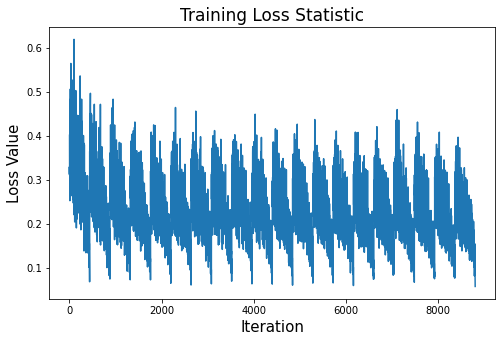


 Starting Validation ... 
Iteration #50 loss: 0.3272661566734314
Iteration #100 loss: 0.4661410450935364
Iteration #150 loss: 0.40169230103492737
Iteration #200 loss: 0.14653834700584412

Final loss: 0.5399660599163988
Completed Fold 4 in 13870.78 seconds


In [42]:
for fold in range(num_folds):
    run_fold(fold)

In [43]:
!mv fasterrcnn_model_* /content/drive/MyDrive/KDT/offline/project/new_ver/20e/

## visualize model

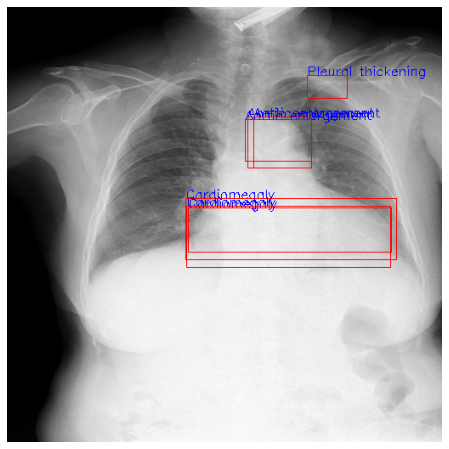

In [41]:
images, targets, image_ids = next(iter(valid_data_loader))

images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

boxes = targets[1]['boxes'].cpu().numpy().astype(np.int32)
sample = images[1].permute(1,2,0).cpu().numpy()
clss = targets[1]['labels'].cpu().numpy().astype(np.int32)

model.eval()
cpu_device = torch.device("cpu")

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
for box, clas in zip(boxes, clss):
    cv2.putText(sample, f"{classes[clas]}", (box[0], box[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1)
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 1)
    
ax.set_axis_off()
ax.imshow(sample)

## inference

In [42]:
train_dir = '/content/vinbigdata/train'
test_dir =  '/content/vinbigdata/test'
train_df = pd.read_csv('/content/vinbigdata/train.csv')
test_df = pd.read_csv('/content/vinbigdata/sample_submission.csv')
test_df.head()

,image_id,PredictionString
0,002a34c58c5b758217ed1f584ccbcfe9,14 1 0 0 1 1
1,004f33259ee4aef671c2b95d54e4be68,14 1 0 0 1 1
2,008bdde2af2462e86fd373a445d0f4cd,14 1 0 0 1 1
3,009bc039326338823ca3aa84381f17f1,14 1 0 0 1 1
4,00a2145de1886cb9eb88869c85d74080,14 1 0 0 1 1


In [43]:
class VinBigTestDataset(Dataset):
    
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()
        
        self.image_ids = dataframe["image_id"].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        
    def __getitem__(self, index):
        
        image_id = self.image_ids[index]
        records = self.df[(self.df['image_id'] == image_id)]
        
        image = cv2.imread(f'{self.image_dir}/{image_id}.png', cv2.IMREAD_COLOR)    
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0 #normalization

        
        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']

        return image, image_id
    
    def __len__(self):
        return self.image_ids.shape[0]

In [44]:
def get_test_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ])

In [46]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False) #내 weight upload하려고 이번엔 false

num_classes = 15  # 14 classes + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.load_state_dict(torch.load('/content/drive/MyDrive/KDT/offline/project/new_ver/20e/fasterrcnn_model_4.pt')) #weight upload
model.eval()

x = model.to(device)

In [47]:
def collate_fn(batch):
    return tuple(zip(*batch))

test_dataset = VinBigTestDataset(test_df, test_dir, get_test_transform())

test_data_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=1, #gpu 개수
    drop_last=False,
    collate_fn=collate_fn
)

In [48]:
def format_prediction_string(labels, boxes, scores):
    pred_strings = []
    for j in zip(labels, scores, boxes):
        pred_strings.append("{0} {1:.4f} {2} {3} {4} {5}".format(
            j[0], j[1], j[2][0], j[2][1], j[2][2], j[2][3]))

    return " ".join(pred_strings)

In [49]:
detection_threshold = 0.4
results = []

with torch.no_grad():

    for images, image_ids in test_data_loader:

        images = list(image.to(device) for image in images)
        outputs = model(images)

        for i, image in enumerate(images):

            image_id = image_ids[i]

            result = {
                'image_id': image_id,
                'PredictionString': '14 1.0 0 0 1 1'
            }

            boxes = outputs[i]['boxes'].data.cpu().numpy()
            labels = outputs[i]['labels'].data.cpu().numpy()
            scores = outputs[i]['scores'].data.cpu().numpy()

            if len(boxes) > 0:
                labels = labels - 1
                labels[labels == -1] = 14

                selected = scores >= detection_threshold

                boxes = boxes[selected].astype(np.int32)
                scores = scores[selected]
                labels = labels[selected]

                if len(boxes) > 0:
                    result = {
                        'image_id': image_id,
                        'PredictionString': format_prediction_string(labels, boxes, scores)
                    }


            results.append(result)

In [50]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.head()

,image_id,PredictionString
0,002a34c58c5b758217ed1f584ccbcfe9,3 0.9806 174 240 416 319
1,004f33259ee4aef671c2b95d54e4be68,0 0.9956 257 99 311 146
2,008bdde2af2462e86fd373a445d0f4cd,0 0.9975 321 145 387 220 3 0.9905 241 247 429 317
3,009bc039326338823ca3aa84381f17f1,3 0.9982 167 231 402 301 6 0.4079 74 88 182 266
4,00a2145de1886cb9eb88869c85d74080,3 0.9984 174 273 455 360 0 0.9882 269 149 323 204


In [51]:
sample = images[1].permute(1,2,0).cpu().numpy()
boxes = outputs[1]['boxes'].data.cpu().numpy().astype(np.int32)
scores = outputs[1]['scores'].data.cpu().numpy()
clss = outputs[1]['labels'].data.cpu().numpy().astype(np.int32)

boxes = boxes[scores >= detection_threshold].astype(np.int32)

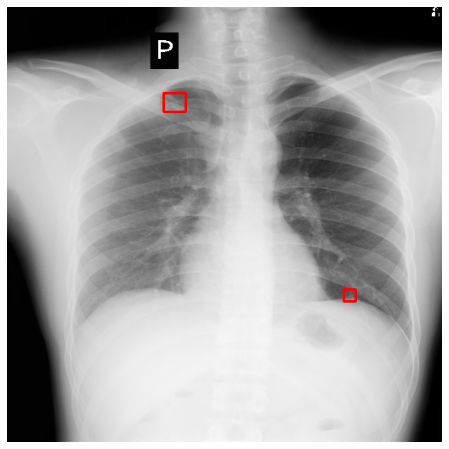

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 2)
    
ax.set_axis_off()
ax.imshow(sample)

In [53]:
test_df.to_csv('A_20e_5fold.csv', index=False)

In [54]:
!mv A_20e_5fold.csv /content/drive/MyDrive/KDT/offline/project/new_ver

## inference 한 결과 visualizing

In [ ]:
import pandas as pd
test_df = pd.read_csv('/content/drive/MyDrive/KDT/offline/project/predictionresult/Adata_20epoch_submission.csv')
test_df

,image_id,PredictionString
0,002a34c58c5b758217ed1f584ccbcfe9,3 0.9835 176 236 406 328 11 0.5957 300 57 399 ...
1,004f33259ee4aef671c2b95d54e4be68,0 0.9830 256 99 313 159 3 0.6406 202 244 389 305
2,008bdde2af2462e86fd373a445d0f4cd,0 0.9888 309 146 387 217 3 0.9494 242 244 429 325
3,009bc039326338823ca3aa84381f17f1,3 0.9511 169 224 389 279 0 0.8940 257 97 311 1...
4,00a2145de1886cb9eb88869c85d74080,3 0.9908 184 271 445 358 0 0.8963 271 150 323 205
...,...,...
2995,ff91fb82429a27521bbec8569b041f02,0 0.9918 274 103 313 157 3 0.9580 209 238 397 ...
2996,ff9fcc4087ed5e941209aa3fa948e364,0 0.9700 256 124 318 199 0 0.9614 185 125 323 ...
2997,ffaa288c8abca300974f043b57d81521,10 0.8493 330 269 437 367 10 0.7272 365 249 43...
2998,ffc441e0c8b7153844047483a577e7c3,14 1.0 0 0 1 1


In [55]:
test_dir =  '/content/vinbigdata/test/'

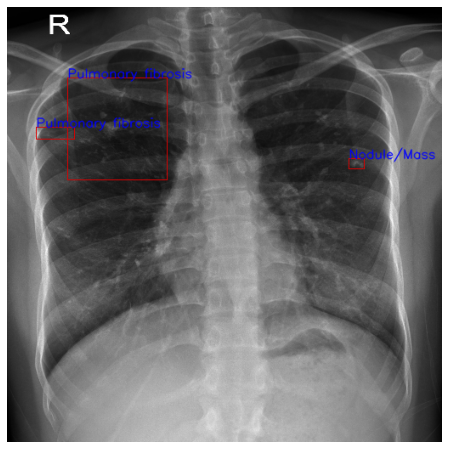

In [56]:
samp_data = test_df.iloc[13].PredictionString.split(' ')
samp_len = len(samp_data)

img0_labels = []
img0_bboxes = []

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
img0 = cv2.imread(test_dir + test_df.iloc[13].image_id +'.png', cv2.IMREAD_COLOR)
img0_labels = [samp_data[i] for i in range(samp_len) if i % 6 == 0]
img0_bboxes = [samp_data[i] for i in range(samp_len) if i % 6 != 0 and i % 6 != 1]

cnt = 0
for cls in img0_labels:
  img0 = cv2.rectangle(img0,
                       (int(img0_bboxes[cnt]), int(img0_bboxes[cnt + 1])),
                       (int(img0_bboxes[cnt + 2]), int(img0_bboxes[cnt + 3])),
                       (220, 0, 0), 1)
  img0 = cv2.putText(img0, label_to_name(int(cls)+1), (int(img0_bboxes[cnt]), int(img0_bboxes[cnt + 1])), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)
  cnt += 4


ax.set_axis_off()
ax.imshow(img0)